# Data science final project - Ofir Cohen and Doron Sionov

##                     Generating famous pages' Facebook posts

## Step 1 - Information collection

We will use the facebook sdk to perform facebook grpah api calls.

The following facebook api code is commented out to save time in future runs. the post will be loaded from a file we have created.

In [207]:
#!pip install facebook-sdk

Obtaining graph instance: 

In [208]:
#import facebook
#import requests

#graph = facebook.GraphAPI(access_token="ommited for privacy concerns")

### Collecting posts

Now that we have a graph instance, we will use it to get our 5 pages posts.
We define a generic function to iterate over facebook graph api pages to retrieve all posts, and call it with our 5 pages. 
Note - if we want different pages, we can easily replace pages by giving a different url to the getAllPosts function call

In [209]:
def getAllPosts(pageURL):
    FirstPosts = graph.get_object(id=pageURL, fields="posts",limit = "100")['posts']
    allPosts = []
    while(True):
        try:
            for post in FirstPosts['data']:
                if(len(allPosts)<150):
                    if('message' in post):
                        allPosts.append(post['message'])
                    FirstPosts=requests.get(FirstPosts['paging']['next']).json()
                else:
                    return(allPosts)
        except KeyError:
            break
    return(allPosts)

We chose these 5 pages:
Donald Trump,
Barack Obama,
Humans of New York,
Harvard University
and 
Fox news.

In [210]:
#TrumpPosts = getAllPosts("https://www.facebook.com/DonaldTrump/")
#ObamaPosts = getAllPosts("https://www.facebook.com/barackobama/")
#HONYPosts = getAllPosts("https://www.facebook.com/humansofnewyork/")
#HarvardPosts = getAllPosts("https://www.facebook.com/Harvard/")
#FoxPosts = getAllPosts("https://www.facebook.com/FoxNews/")

Here we write the posts to two files, one that is human friendly and easy to read:

In [211]:
#collectedPostsFile = open('collectedPosts-Readable.txt', 'w',encoding = 'utf-8')
#for i,page in enumerate(allposts):
#    collectedPostsFile.write("\n The " + pagesNames[i] + " page posts are:"+  "\n" + "\n")
#    for post in page:
#        collectedPostsFile.write("%s\n" % post)
#collectedPostsFile.close()

And one that is used as input for the rest of the code:

In [212]:
#collectedPostsFile = open('collectedPosts-AsInput.txt', 'w',encoding = 'utf-8')
#collectedPostsFile.write(str(allposts))
#collectedPostsFile.close()

Reading posts from the input file:

In [213]:
import ast
collectedPostsFile = open('collectedPosts-AsInput.txt', 'r',encoding = 'utf-8')
allposts = collectedPostsFile.read()
allposts = ast.literal_eval(allposts)
collectedPostsFile.close()
TrumpPosts = allposts[0]
ObamaPosts = allposts[1]
HONYPosts = allposts[2]
HarvardPosts = allposts[3]
FoxPosts = allposts[4]

### Describing the data

Every facebook page has mulitple types of publishes - pictures, videos, posts, stories etc. 
So, it is often not possible to collect large amount of textual posts from a page.
Therefore we would start by looking at the amount of posts we collected, and look at 5 from each page.

In [214]:
allposts = [TrumpPosts,ObamaPosts,HONYPosts,HarvardPosts,FoxPosts]
pagesNames = ["Donald Trump","Barack Obama","Humans of New York","Harvard University","Fox news"]
index = 0
for page in allposts:
    print("In the page of ",pagesNames[index], " we collected ",len(page), " posts\n")
    print("The latest 5 posts in this page are: \n",)
    for post in page[0:5]:
        print(post,"\n")
    print("\n")
    index = index + 1

In the page of  Donald Trump  we collected  121  posts

The latest 5 posts in this page are: 

Today, it was my great honor to host a School Safety Roundtable at the White House with State and local leaders, law enforcement officers, and education officials.

There is nothing more important than protecting our children. They deserve to be safe, and we will deliver! 

History shows that a school shooting lasts, on average, 3 minutes. It takes police & first responders approximately 5 to 8 minutes to get to site of crime. Highly trained, gun adept, teachers/coaches would solve the problem instantly, before police arrive. GREAT DETERRENT! 

I will be strongly pushing Comprehensive Background Checks with an emphasis on Mental Health. Raise age to 21 and end sale of Bump Stocks! 

Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? 

President Donald J. Trump's schedule for Thursday,

Lets look at minumun,maximun and average length of the posts.

In [215]:
minLength = len(TrumpPosts[0])
maxLength = 0
avg = 0
count = 0
sumLength = 0
for page in allposts:
    for post in page:
        count = count + 1
        sumLength = sumLength + len(post)
        if(len(post) < minLength):
            minLength = len(post)
        if(len(post)>maxLength):
            maxLength = len(post)
avg = sumLength/count
print("The longest post is ", maxLength," characters long\n")
print("The shortest post is ", minLength," characters long\n")
print("The avergae length of the posts is ", avg," characters long\n")

The longest post is  5599  characters long

The shortest post is  7  characters long

The avergae length of the posts is  249.08944281524927  characters long



## Step 2 - Creating a classifier for the different pages

### Data cleaning

We start by cleaning the posts' text.
First, we remove non english letters since we are collecting posts from offical facebook pages, and therefore punctuation such as ":)" is not likely to be found.

In [216]:
import re
onlyEnglish=[]
for page in allposts:
    englishPagePost=[]
    for post in page:
        englishPost = re.sub("[^a-zA-Z]", " ",post)
        englishPagePost.append(englishPost)
    onlyEnglish.append(englishPagePost)

Lets look at the first post of every page after this stage:

In [217]:
for page in onlyEnglish:
    print(page[0])
    print("\n")

Today  it was my great honor to host a School Safety Roundtable at the White House with State and local leaders  law enforcement officers  and education officials   There is nothing more important than protecting our children  They deserve to be safe  and we will deliver 


Today  Kehinde Wiley and Amy Sherald became the first black artists to create official presidential portraits for the Smithsonian  To call this experience humbling would be an understatement    Thanks to Kehinde and Amy  generations of Americans   and young people from all around the world   will visit the National Portrait Gallery and see this country through a new lens  They ll walk out of that museum with a better sense of the America we all love  Clear eyed  Big hearted  Inclusive and optimistic   And I hope they ll walk out more empowered to go and change their worlds 


 I feel like God has given me a talent for art  and using that talent is a form of gratitude   For years I worked in an automotive workshop   

We continue to clean the data by converting the posts to lower case, and split each post to words.

In [218]:
lowerCaseWords=[]
for page in onlyEnglish:
    pagePostsWords=[]
    for post in page:
        words = post.lower().split()                 
        pagePostsWords.append(words)
    lowerCaseWords.append(pagePostsWords)

Lets look at the first post of every page after this stage:

In [219]:
for page in lowerCaseWords:
    print(page[0])
    print("\n")

['today', 'it', 'was', 'my', 'great', 'honor', 'to', 'host', 'a', 'school', 'safety', 'roundtable', 'at', 'the', 'white', 'house', 'with', 'state', 'and', 'local', 'leaders', 'law', 'enforcement', 'officers', 'and', 'education', 'officials', 'there', 'is', 'nothing', 'more', 'important', 'than', 'protecting', 'our', 'children', 'they', 'deserve', 'to', 'be', 'safe', 'and', 'we', 'will', 'deliver']


['today', 'kehinde', 'wiley', 'and', 'amy', 'sherald', 'became', 'the', 'first', 'black', 'artists', 'to', 'create', 'official', 'presidential', 'portraits', 'for', 'the', 'smithsonian', 'to', 'call', 'this', 'experience', 'humbling', 'would', 'be', 'an', 'understatement', 'thanks', 'to', 'kehinde', 'and', 'amy', 'generations', 'of', 'americans', 'and', 'young', 'people', 'from', 'all', 'around', 'the', 'world', 'will', 'visit', 'the', 'national', 'portrait', 'gallery', 'and', 'see', 'this', 'country', 'through', 'a', 'new', 'lens', 'they', 'll', 'walk', 'out', 'of', 'that', 'museum', 'with

Now, we will remove stop words from our posts.

In [220]:
import nltk
#nltk.download()

In [221]:
from nltk.corpus import stopwords
noStopWords=[]
for page in lowerCaseWords:
    pagePostsWithoutStopWords=[]
    for post in page:
        words = [w for w in post if not w in stopwords.words("english")]                 
        pagePostsWithoutStopWords.append(words)
    noStopWords.append(pagePostsWithoutStopWords)

lets look at the first post of every page after this stage:

In [222]:
for page in noStopWords:
    print(page[0])
    print("\n")

['today', 'great', 'honor', 'host', 'school', 'safety', 'roundtable', 'white', 'house', 'state', 'local', 'leaders', 'law', 'enforcement', 'officers', 'education', 'officials', 'nothing', 'important', 'protecting', 'children', 'deserve', 'safe', 'deliver']


['today', 'kehinde', 'wiley', 'amy', 'sherald', 'became', 'first', 'black', 'artists', 'create', 'official', 'presidential', 'portraits', 'smithsonian', 'call', 'experience', 'humbling', 'would', 'understatement', 'thanks', 'kehinde', 'amy', 'generations', 'americans', 'young', 'people', 'around', 'world', 'visit', 'national', 'portrait', 'gallery', 'see', 'country', 'new', 'lens', 'walk', 'museum', 'better', 'sense', 'america', 'love', 'clear', 'eyed', 'big', 'hearted', 'inclusive', 'optimistic', 'hope', 'walk', 'empowered', 'go', 'change', 'worlds']


['feel', 'like', 'god', 'given', 'talent', 'art', 'using', 'talent', 'form', 'gratitude', 'years', 'worked', 'automotive', 'workshop', 'try', 'paint', 'came', 'home', 'never', 'ener

Finally, we join the word list back into a sentence

In [223]:
cleanedPosts=[]
for page in noStopWords:
    pageCleanedPosts=[]
    for post in page:
        cleaned = " ".join(post)                 
        pageCleanedPosts.append(cleaned)
    cleanedPosts.append(pageCleanedPosts)

Lets see our fully cleaned posts, the first from each page:

In [224]:
for page in cleanedPosts:
    print(page[0])
    print("\n")

today great honor host school safety roundtable white house state local leaders law enforcement officers education officials nothing important protecting children deserve safe deliver


today kehinde wiley amy sherald became first black artists create official presidential portraits smithsonian call experience humbling would understatement thanks kehinde amy generations americans young people around world visit national portrait gallery see country new lens walk museum better sense america love clear eyed big hearted inclusive optimistic hope walk empowered go change worlds


feel like god given talent art using talent form gratitude years worked automotive workshop try paint came home never energy left finally quit freedom develop talents easy art difficult country really seen profession would easier alone family support lot pressure earn trying tough poverty read lot poetry give strength would never beg right drawing portraits caricatures support rather painting think feel fulfill co

### Moving to Structured Data - Bag of words

Now that we have all data in a clean format, we can represent it as a bag of words in order to build our classifier.
We chose max features to be 400 after we tried different numbers and noticed the results.

In [225]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None, max_features = 400)
labelsForPosts=[]
index = 0
for page in cleanedPosts:
    for post in page:
        labelsForPosts.append(index)
    index= index+1
allCleanedPosts = cleanedPosts[0]+cleanedPosts[1]+cleanedPosts[2]+cleanedPosts[3]+cleanedPosts[4]
train_data_features = vectorizer.fit_transform(allCleanedPosts)
train_data_features = train_data_features.toarray()

### Building the classifier

First we split the data into train and test sets. Then, we will try three different classifiers and select the best one.

In [226]:
import numpy
msk = numpy.random.rand(len(allCleanedPosts)) < 0.8
index = 0
train_x = []
train_y = []
test_x = []
test_y = []

for post in train_data_features:
    if(msk[index]):
        train_x.append(train_data_features[index])
        train_y.append(labelsForPosts[index])   
    else:
        test_x.append(train_data_features[index])
        test_y.append(labelsForPosts[index])   
    index = index + 1

###Random Forest

Training Random Forest model:

In [227]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 90) 
forest = forest.fit(numpy.vstack(train_x), numpy.ravel(numpy.vstack(train_y )))
ForestScore = forest.score(numpy.vstack(test_x),numpy.ravel(numpy.vstack(test_y)))
ForestScore

0.75177304964539005

###SVM

Training SVM model:

In [228]:
from sklearn import svm
SvmModel = svm.SVC()
SvmModel.fit(train_x, train_y)
SVMScore = SvmModel.score(numpy.vstack(test_x), numpy.vstack(test_y))
SVMScore

0.42553191489361702

###KNN

Training KNN model:

In [229]:
from sklearn.neighbors import KNeighborsClassifier
KNNModel = KNeighborsClassifier(n_neighbors=10)
KNNModel.fit(train_x, train_y)
KNNScore = KNNModel.score(numpy.vstack(test_x), numpy.vstack(test_y))
KNNScore

0.57446808510638303

Lets Comapre the results and decide on our finale classifier:

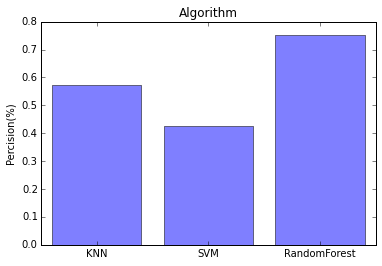

In [230]:
import matplotlib.pyplot as plt;
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('KNN', 'SVM', 'RandomForest')
y_pos = np.arange(len(objects))
performance = [KNNScore,SVMScore,ForestScore]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percision(%)')
plt.title('Algorithm')
 
plt.show()

As we can see, Random forset has the best results and thus we will use it as our classifier in step 4.

## Step 3 - Generating posts

In [231]:
#!pip install keras==1.2
#!pip install theano
#from keras import backend as K
#K.set_image_dim_ordering('th')
import keras
print(keras.__version__)
import theano

1.2.0


We define the following tokens and a vocabulary of size 600, to get only most common words:

In [232]:
vocabulary_size = 600
next_post_toekn = "NEXTPOST"
unknown_token = "UNKNOWNTOKEN"
sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"
line_break= "NEWLINE"
separator= "SEPARATOR"

Next, we insert the above tokens into all of the posts: 

In [233]:
trumpPostsCombined = ''
obamaPostsCombined = ''
honyPostsCombined = ''
harvardPostsCombined = ''
foxPostsCombined = ''
allpostsCombined = [trumpPostsCombined,obamaPostsCombined,honyPostsCombined,harvardPostsCombined,foxPostsCombined]
index = 0
for page in allposts:
    for post in page:
        post_with_tokens = next_post_toekn + ' ' + sentence_start_token + " " + post
        post_with_tokens = post_with_tokens.replace('\n',' '+ line_break + ' ')
        post_with_tokens = post_with_tokens.replace('--',' '+ separator + ' ')
        post_with_tokens = post_with_tokens.replace('.',' '+sentence_end_token +' '+ sentence_start_token+' ' )
        allpostsCombined[index] = allpostsCombined[index] + ' ' + post_with_tokens
    allpostsCombined[index] = allpostsCombined[index][1:]
    index +=1
allpostsCombined

['NEXTPOST SENTENCESTART Today, it was my great honor to host a School Safety Roundtable at the White House with State and local leaders, law enforcement officers, and education officials SENTENCEEND SENTENCESTART  NEWLINE  NEWLINE There is nothing more important than protecting our children SENTENCEEND SENTENCESTART  They deserve to be safe, and we will deliver! NEXTPOST SENTENCESTART History shows that a school shooting lasts, on average, 3 minutes SENTENCEEND SENTENCESTART  It takes police & first responders approximately 5 to 8 minutes to get to site of crime SENTENCEEND SENTENCESTART  Highly trained, gun adept, teachers/coaches would solve the problem instantly, before police arrive SENTENCEEND SENTENCESTART  GREAT DETERRENT! NEXTPOST SENTENCESTART I will be strongly pushing Comprehensive Background Checks with an emphasis on Mental Health SENTENCEEND SENTENCESTART  Raise age to 21 and end sale of Bump Stocks! NEXTPOST SENTENCESTART Question: If all of the Russian meddling took pl

After tokenning our posts, we split them to words:

In [234]:
from keras.preprocessing.text import text_to_word_sequence
allpostsAsSequence= []
for post in allpostsCombined:
    allpostsAsSequence.append(text_to_word_sequence(post, lower=False, split=" "))
allpostsAsSequence

[['NEXTPOST',
  'SENTENCESTART',
  'Today',
  'it',
  'was',
  'my',
  'great',
  'honor',
  'to',
  'host',
  'a',
  'School',
  'Safety',
  'Roundtable',
  'at',
  'the',
  'White',
  'House',
  'with',
  'State',
  'and',
  'local',
  'leaders',
  'law',
  'enforcement',
  'officers',
  'and',
  'education',
  'officials',
  'SENTENCEEND',
  'SENTENCESTART',
  'NEWLINE',
  'NEWLINE',
  'There',
  'is',
  'nothing',
  'more',
  'important',
  'than',
  'protecting',
  'our',
  'children',
  'SENTENCEEND',
  'SENTENCESTART',
  'They',
  'deserve',
  'to',
  'be',
  'safe',
  'and',
  'we',
  'will',
  'deliver',
  'NEXTPOST',
  'SENTENCESTART',
  'History',
  'shows',
  'that',
  'a',
  'school',
  'shooting',
  'lasts',
  'on',
  'average',
  '3',
  'minutes',
  'SENTENCEEND',
  'SENTENCESTART',
  'It',
  'takes',
  'police',
  'first',
  'responders',
  'approximately',
  '5',
  'to',
  '8',
  'minutes',
  'to',
  'get',
  'to',
  'site',
  'of',
  'crime',
  'SENTENCEEND',
  'SENTE

We than create the tokens and matrixes for each post:

In [235]:
from keras.preprocessing.text import Tokenizer
tokens = []
text_mtxs = []
for seq in allpostsAsSequence:
    token = Tokenizer(nb_words=vocabulary_size,char_level=False)
    token.fit_on_texts(seq)
    text_mtx = token.texts_to_matrix(seq, mode='binary')
    tokens.append(token)
    text_mtxs.append(text_mtx)

And creating the vocabulary of each page:

In [236]:
import pandas as pd
import numpy as np
index = 0
vocabs = []
for seq in allpostsAsSequence:
    vocab = pd.DataFrame({'word':seq,'code':np.argmax(text_mtxs[index],axis=1)})
    vocab=vocab.drop_duplicates()
    vocabs.append(vocab)
    index += 1

In [237]:
vocabs

[      code             word
 0        4         NEXTPOST
 1        1    SENTENCESTART
 2       46            Today
 3       26               it
 4       43              was
 5       34               my
 6       13            great
 7       91            honor
 8        6               to
 9      463             host
 10       9                a
 11     161           School
 12     237           Safety
 13       0       Roundtable
 14      29               at
 15       3              the
 16     124            White
 17     172            House
 18      16             with
 19     151            State
 20       5              and
 21     186            local
 22     219          leaders
 23     104              law
 24     216      enforcement
 25     321         officers
 27       0        education
 28     408        officials
 29       2      SENTENCEEND
 31       8          NEWLINE
 ...    ...              ...
 3979     0            fired
 3981     0             give
 3982     0   

Creating inputs and outputs for each page's network:

In [238]:
inputs = []
outputs = []
for text_mat in text_mtxs:
    inputs.append(text_mat[:-1])
    outputs.append(text_mat[1:])

In [239]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding

Assembling a model for each page:

In [240]:
models = []
index = 0
for input_ in inputs:
    model = Sequential()
    model.add(Embedding(input_dim=input_.shape[1],output_dim= 42, input_length=input_.shape[1]))
    model.add(Flatten())
    model.add(Dense(outputs[index].shape[1], activation='sigmoid'))
    index += 1
    models.append(model)

Compiling all the models:

In [241]:
for model in models:
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

The model training is commented out to save time in future runs. We will load the models' weights from backup files.

Training the models:(we tried many options for the parameters and found these to be optimal)

In [242]:
#index = 0
#for model in models:
#    if(index == 2):
#        model.fit(inputs[index], y=outputs[index], batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)
#    else:
#        model.fit(inputs[index], y=outputs[index], batch_size=200, nb_epoch=100, verbose=1, validation_split=0.2)
#    index +=1

Creating backup files for the models:

In [243]:
#for i,model in enumerate(models):
#    if(i==2):
#        model.save_weights('model' + str(i) + '_weights_50.h5')
#    else:
#        model.save_weights('model' + str(i) + '_weights_100.h5')

Load the models from backup files:

In [244]:
for i,model in enumerate(models):
    if(i==2):
        model.load_weights('model' + str(i) + '_weights_50.h5')
    else:
        model.load_weights('model' + str(i) + '_weights_100.h5')

Reviewing model scores:

In [245]:
index = 0
scores = []
for model in models:
    scores.append(model.evaluate(inputs[index],outputs[index], verbose=0))
    index += 1    

In [246]:
scores

[[2.6843269331494541, 0.325412221158973],
 [6.6197536308222098, 0.11460640967077104],
 [4.9915621432318522, 0.19566851131205204],
 [5.441492918585829, 0.1596476149644829],
 [6.2105613746207036, 0.16172381835262606]]

### Generating new text

We define a function that given a word,token,model and a vocabulary will return the next word in an undeterministic fashion:
The function will choose one of the words the are in the top 1% in terms of probability, to follow the given word.
the 0.99 parameter can be replaced to create stronger/weaker relations between two adjacent words.
However, the higher the parameter the less options there are for a following word, i.e more deterministic and more posts that will be similar.

In [247]:
import random
def get_next_non_deter(text,token,model,vocabulary):
    #converting the word to 1-hot matrix represenation
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    #predicting next word
    sortedProbas = sorted(model.predict(tmp)[0])
    possibleWords = sortedProbas[int(len(sortedProbas) * .99) :]
    selectedWordIndex=random.randint(0, len(possibleWords)-1)
    wordOriginalIndex = -1
    for i,val in enumerate(model.predict(tmp)[0]):
            if(possibleWords[selectedWordIndex] == val):
                wordOriginalIndex = i
    if(wordOriginalIndex == -1):
         return get_next_non_deter(text,token,model,vocabulary)
    else:
        return vocabulary[vocabulary['code']==wordOriginalIndex]['word'].values[0]

This function creats the new posts by starting with a sentence-start token and then predicting word by word using the above function:

In [248]:
def create_new_post(token,model,vocab):
    firstWord = 'SENTENCESTART'
    post = firstWord
    nextWord = ''
    sentenceCounter = 0
    while(nextWord != 'NEXTPOST' and sentenceCounter<=5):
        nextWord = get_next_non_deter(firstWord,token,model,vocab)
        if(nextWord == "SENTENCEEND"):
            sentenceCounter +=1
        post = post + ' ' +  nextWord
        firstWord = nextWord
    return post[:-9]

After the post has been created. we subtitute every token with its original text: (if a post is shorter than 3 words, we create a new one instead).

In [249]:
def replace_tokens(post):
    post_without_tokens = post.replace('SENTENCESTART','')
    post_without_tokens = post_without_tokens.replace('SENTENCEEND','. ')
    post_without_tokens = post_without_tokens.replace('NEWLINE','\n')
    return post_without_tokens

We comment out the post generation code, in order for the generate post to be persistent(make sure that our posts and the graders posts are the same).

In [250]:
#generatedPosts = []
#i=0
#for index in range(5):
#    pagePosts = []
#    while(i<30):
#        post = create_new_post(tokens[index],models[index],vocabs[index])
#        post = replace_tokens(post)
#        if (len(post.split(' ')) >3):
#            pagePosts.append(post)
#            i += 1
#    generatedPosts.append(pagePosts)
#    i=0

We save the generated posts in two files, one that is human friendly and easy to read:

In [251]:
#generatedPostsFile = open('generatedPosts-Readable.txt', 'w',encoding='utf-8')
#for i,page in enumerate(generatedPosts):
#    generatedPostsFile.write("\n The " + pagesNames[i] + " page posts are:"+  "\n" + "\n")
#    for post in page:
#        generatedPostsFile.write("%s\n" % post)
#generatedPostsFile.close()

And one that is used as input for the next step:

In [252]:
#generatedPostsFile = open('generatedPosts-AsInput.txt', 'w',encoding='utf-8')
#generatedPostsFile.write(str(generatedPosts))
#generatedPostsFile.close()

Here we load the posts from the backup files instead of creating new posts in every run:

In [253]:
generatedPostsFile = open('generatedPosts-AsInput.txt', 'r',encoding='utf-8')
generatedPosts = generatedPostsFile.read()
generatedPosts = ast.literal_eval(generatedPosts)
generatedPostsFile.close()

In [254]:
generatedPosts

[[' we Have to Have',
  ' He will be one by a School of our children .  .   we must keep us safe',
  ' \n Mr in this morning America',
  ' He has No of people crazies in great job and the Obama Administration \n Mr for her many to the great Billy Graham .   \n in America .  or in my commitment the flags half to be a School shooting in America safe of people and all Trump is in my unbelievable family for President Donald in America first responders .  or the great honor all',
  " the last week's .  or of America .  .   \n Mr in honor",
  ' the flags in honor',
  ' we Thank in this morning',
  ' He has No matter our first White in honor all Americans and the Fake for all Trump and all',
  ' we must not ObamaCare .  with No',
  ' He should be the last several and I want you for the great Billy in America first energy in this shows Small Business man to know Reverend in this TOGETHER .  .  .  in this President’s of America safe great honor',
  ' we Thank for the President Obama Administrat

## step 4 - Classifying generated posts

In order to classify the generated posts, we first transfer them into a bag of words:

In [255]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None, max_features = 400)
labelsForPosts=[]
index = 0
for page in generatedPosts:
    for post in page:
        labelsForPosts.append(index)
    index= index+1
allGeneratedPosts = generatedPosts[0]+generatedPosts[1]+generatedPosts[2]+generatedPosts[3]+generatedPosts[4]
generatedPosts_train_data_features = vectorizer.fit_transform(allGeneratedPosts)
generatedPosts_train_data_features = generatedPosts_train_data_features.toarray()

Then we use the Random Forest model from step 2, to predict(classify) each generated post:

In [256]:
predictions = forest.predict(generatedPosts_train_data_features)

Lest calculate the precision of the classification:

In [257]:
TrumpTruePred= 0
ObamaTruePred= 0
HONYTruePred= 0
HarvardTruePred= 0
FoxTruePred= 0
for i in range(5):
    for j in range(30):
        if(i==0 and predictions[j] == i ):
            TrumpTruePred+=1
        elif(i==1 and predictions[j] == i ):
            ObamaTruePred+=1
        elif(i==2 and predictions[j] == i ):
            HONYTruePred+=1
        elif(i==3 and predictions[j] == i ):
            HarvardTruePred+=1
        elif(i==4 and predictions[j] == i ):
            FoxTruePred+=1
print("We got the following precision:")
print("The classifier predicted " +str(100*TrumpTruePred/30) + "% of Trump posts correctly\n")
print("The classifier predicted " +str(100*ObamaTruePred/30) + "% of Obama posts correctly\n")
print("The classifier predicted " +str(100*HONYTruePred/30) + "% of Humans of New York posts correctly\n")
print("The classifier predicted " +str(100*HarvardTruePred/30) + "% of Harvard posts correctly\n")
print("The classifier predicted " +str(100*FoxTruePred/30) + "% of Fox News posts correctly\n")

We got the following precision:
The classifier predicted 6.666666666666667% of Trump posts correctly

The classifier predicted 3.3333333333333335% of Obama posts correctly

The classifier predicted 23.333333333333332% of Humans of New York posts correctly

The classifier predicted 40.0% of Harvard posts correctly

The classifier predicted 26.666666666666668% of Fox News posts correctly



Plotting the confusion matrix:

[[ 2  1  7 12  8]
 [ 9  3  7  4  7]
 [ 0 23  3  0  4]
 [ 0  0  8 13  9]
 [ 1 15  6  4  4]]


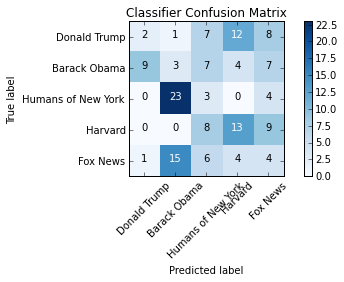

In [258]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['Donald Trump','Barack Obama', 'Humans of New York','Harvard','Fox News']
cnfMatrix = confusion_matrix(labelsForPosts, predictions)
np.set_printoptions(precision=2)
print(cnfMatrix)

plt.imshow(cnfMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Classifier Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cnfMatrix.max() / 2.
for i, j in itertools.product(range(cnfMatrix.shape[0]), range(cnfMatrix.shape[1])):
    plt.text(j, i, format(cnfMatrix[i, j], fmt), horizontalalignment="center", color="white" if cnfMatrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plt.show()